In [1]:
import tensorflow as tf
import keras
from keras.preprocessing import image
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
from keras.preprocessing.image import ImageDataGenerator 
import numpy as np
from sklearn.utils import shuffle
from keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.regularizers import l2

In [2]:
#Image directory and csv path
image_dir = "./ISIC-images"
csv_label = pd.read_csv("class_label1.csv")
one_hot = pd.get_dummies(csv_label["category"])
test3 = pd.concat([csv_label, one_hot], axis=1)

train_df, test_df = train_test_split(test3, random_state=80, test_size=0.2)

In [3]:
BATCH_SIZE = 32
INPUT_SIZE = (224, 224)

# Data Generator
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = image_dir,
    x_col = "name",
    y_col = ["AKIEC","BCC","BKL","DF","MEL","NV","VASC"],
    target_size = INPUT_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "raw"
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory = image_dir,
    x_col = "name",
    y_col = ["AKIEC","BCC","BKL","DF","MEL","NV","VASC"],
    target_size = INPUT_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "raw"
)

Found 18956 validated image filenames.
Found 4739 validated image filenames.


In [4]:
# Define Encoder
densenet = tf.keras.applications.DenseNet169(
    include_top = False, 
    weights = "imagenet",
    input_shape = (224,224,3), 
  )
densenet.Trainable = False

# Define Network
x = GlobalAveragePooling2D()(densenet.output)
x = Dense(units = 256, activation = 'relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(units = 64, activation = 'relu')(x)
pred = Dense(units = 7, activation = 'softmax', kernel_regularizer = l2(l = 0.01))(x)

model = keras.models.Model(inputs = densenet.input, outputs = pred)

# model.summary()

In [5]:
# Compile Model
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics   = ['accuracy']
  )

In [6]:
checkpoint_filepath = './tmp/checkpoint/cp-{epoch:04d}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    period=1,
    mode='auto',
    save_best_only=False)

In [7]:
# Fit model
history = model.fit(
    train_generator,
    steps_per_epoch = 592,
    epochs = 30,
    validation_data = test_generator,
    validation_steps = 148,
    callbacks=[model_checkpoint_callback]
  )

Epoch 1/30
592/592 [==============================] - 859s 1s/step - loss: 0.6972 - accuracy: 0.7811 - val_loss: 0.8827 - val_accuracy: 0.7876
Epoch 2/30
592/592 [==============================] - 866s 1s/step - loss: 0.5931 - accuracy: 0.7910 - val_loss: 0.5856 - val_accuracy: 0.7960
Epoch 3/30
592/592 [==============================] - 870s 1s/step - loss: 0.5535 - accuracy: 0.7945 - val_loss: 0.6062 - val_accuracy: 0.8091
Epoch 4/30
592/592 [==============================] - 880s 1s/step - loss: 0.5301 - accuracy: 0.8017 - val_loss: 0.6428 - val_accuracy: 0.8036
Epoch 5/30
592/592 [==============================] - 872s 1s/step - loss: 0.5166 - accuracy: 0.8057 - val_loss: 0.6004 - val_accuracy: 0.8057
Epoch 6/30
592/592 [==============================] - 872s 1s/step - loss: 0.5067 - accuracy: 0.8103 - val_loss: 0.8371 - val_accuracy: 0.7931
Epoch 7/30
592/592 [==============================] - 868s 1s/step - loss: 0.4950 - accuracy: 0.8137 - val_loss: 0.7320 - val_accuracy: 0.7006

In [8]:
model.save('./densenet_skin_1.h5')

In [9]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

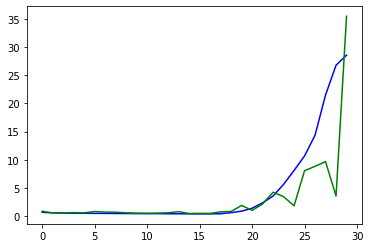

In [10]:
epochs = range(len(loss))
plt.plot(epochs,loss,"b",label="Training loss")
plt.plot(epochs,val_loss,"g",label="validation loss")

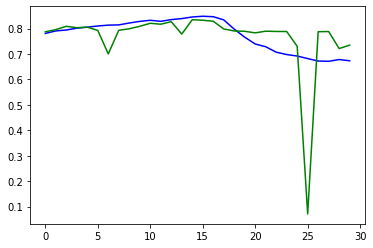

In [11]:
plt.plot(epochs,acc,"b",label="Training accuracy")
plt.plot(epochs,val_acc,"g",label="validation accuracy")